In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error,r2_score
import openpyxl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Importing the dataset
precipitation=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\precipitation.csv")

In [3]:
precipitation

,Year,Month,past,pasttopast,precipitation
0,1990,1,0.000000,0.000000,0.461875
1,1990,2,0.000000,0.000000,0.000000
2,1990,3,0.000000,0.000000,0.000000
3,1990,4,0.000000,0.395000,0.000000
4,1990,5,0.000000,0.000000,2.701875
...,...,...,...,...,...
355,2019,8,1.053750,5.270000,4.875625
356,2019,9,1.580625,5.270000,5.270000
357,2019,10,5.270000,5.205625,6.853750
358,2019,11,7.249375,8.965000,6.919375


In [4]:
precipitation.shape

(360, 5)

In [5]:
precipitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           360 non-null    int64  
 1   Month          360 non-null    int64  
 2   past           360 non-null    float64
 3   pasttopast     360 non-null    float64
 4   precipitation  360 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 14.2 KB


In [6]:
#Creating correlation matrix for precipitation
corr_matrix=precipitation.corr()
corr_matrix

,Year,Month,past,pasttopast,precipitation
Year,1.000000e+00,2.844429e-15,0.028532,0.050290,0.032269
Month,2.844429e-15,1.000000e+00,0.592211,0.587063,0.600713
past,2.853157e-02,5.922107e-01,1.000000,0.547635,0.549992
pasttopast,5.028977e-02,5.870627e-01,0.547635,1.000000,0.519363
precipitation,3.226930e-02,6.007131e-01,0.549992,0.519363,1.000000


In [7]:
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)]= True

c:\Users\C KIRANMAYI\anaconda3\envs\myenv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


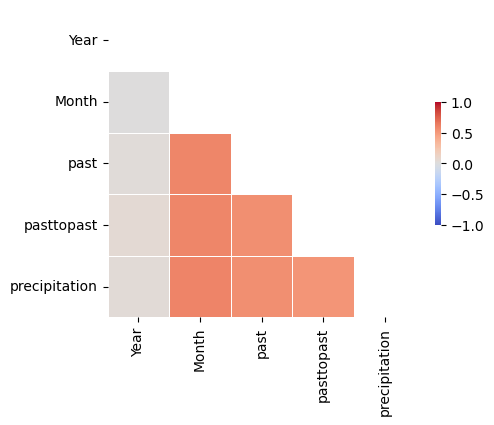

In [8]:
f, ax = plt.subplots(figsize=(5, 4)) 
heatmap = sns.heatmap(corr_matrix, mask = mask,square = True,linewidths = .5, cmap = 'coolwarm', cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},vmin = -1, vmax = 1,annot = True,annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [9]:
precipitation=precipitation.drop(['Year','Month'],axis=1)

In [10]:
precipitation.shape

(360, 3)

In [11]:
X=precipitation.drop('precipitation',axis=1)
y=precipitation.precipitation

In [12]:
X

,past,pasttopast
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.395000
4,0.000000,0.000000
...,...,...
355,1.053750,5.270000
356,1.580625,5.270000
357,5.270000,5.205625
358,7.249375,8.965000


In [13]:
y

0      0.461875
1      0.000000
2      0.000000
3      0.000000
4      2.701875
         ...   
355    4.875625
356    5.270000
357    6.853750
358    6.919375
359    4.085625
Name: precipitation, Length: 360, dtype: float64

In [14]:
X.shape

(360, 2)

In [15]:
y.shape

(360,)

In [16]:
# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping data for LSTM/GRU/RNN (samples, timesteps, features)
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

### GRU

In [17]:
def create_gru_model(units=64):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [18]:
gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_5700\2098133132.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)


In [19]:
# Define the hyperparameter grid
gru_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [20]:
gru_grid = GridSearchCV(estimator=gru_model, param_grid=gru_param_grid, cv=3, scoring='neg_mean_squared_error')

In [21]:
gru_grid_result = gru_grid.fit(X_train, y_train)

In [22]:
print(f"Best GRU params: {gru_grid_result.best_params_}")
print(f"Best GRU score: {gru_grid_result.best_score_}")

Best GRU params: {'batch_size': 16, 'epochs': 50, 'units': 32}
Best GRU score: -5.921737788918633


### LSTM

In [23]:
def create_lstm_model(units=64):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [24]:
lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_5700\1916978622.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [25]:
# Define the hyperparameter grid
lstm_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [26]:
lstm_grid = GridSearchCV(estimator=lstm_model, param_grid=lstm_param_grid, cv=3, scoring='neg_mean_squared_error')

In [27]:
lstm_grid_result = lstm_grid.fit(X_train, y_train)

In [28]:
print(f"Best LSTM params: {lstm_grid_result.best_params_}")
print(f"Best LSTM score: {lstm_grid_result.best_score_}")

Best LSTM params: {'batch_size': 16, 'epochs': 50, 'units': 32}
Best LSTM score: -5.970741652613344


### RNN

In [29]:
def create_rnn_model(units=64):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [30]:
rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_5700\361697586.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)


In [31]:
rnn_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [32]:
rnn_grid = GridSearchCV(estimator=rnn_model, param_grid=rnn_param_grid, cv=3, scoring='neg_mean_squared_error')

In [33]:
rnn_grid_result = rnn_grid.fit(X_train, y_train)

In [34]:
print(f"Best SimpleRNN params: {rnn_grid_result.best_params_}")
print(f"Best SimpleRNN score: {rnn_grid_result.best_score_}")

Best SimpleRNN params: {'batch_size': 16, 'epochs': 100, 'units': 32}
Best SimpleRNN score: -5.86401376628982


In [35]:
# Evaluating GRU model on test data
best_gru_model = gru_grid_result.best_estimator_
y_pred_gru = best_gru_model.predict(X_test)
mse_gru = mean_squared_error(y_test, y_pred_gru)


print(f"GRU Model - MSE: {mse_gru}")

# Evaluating LSTM model on test data
best_lstm_model = lstm_grid_result.best_estimator_
y_pred_lstm = best_lstm_model.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)


print(f"LSTM Model - MSE: {mse_lstm}")

# Evaluating SimpleRNN model on test data
best_rnn_model = rnn_grid_result.best_estimator_
y_pred_rnn = best_rnn_model.predict(X_test)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)


print(f"SimpleRNN Model - MSE: {mse_rnn}")


GRU Model - MSE: 2.9964403576210934
LSTM Model - MSE: 3.111312512455953
SimpleRNN Model - MSE: 2.787846166621704


## RNN is sutaible for Precipitation with least MSE

In [36]:
precipitation2021=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\precipitation.csv")

In [37]:
precipitation2021=precipitation2021.drop(['Year','Month'],axis=1)

In [38]:
precipitation2021

,past,pasttopast
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,1.516250
5,0.000000,0.000000
6,0.856875,0.000000
7,4.875625,1.053750
8,5.270000,1.580625
9,6.853750,5.270000


In [39]:
precipitation2020_pred=[]

In [40]:
precipitation2021_scaled = scaler.transform(precipitation2021)

# Reshape for prediction
precipitation2021_scaled = np.reshape(precipitation2021_scaled, (precipitation2021_scaled.shape[0], precipitation2021_scaled.shape[1], 1))

In [41]:
best_model = rnn_grid_result.best_estimator_
precipitation2020_pred=best_model.predict(precipitation2021_scaled)

In [42]:
precipitation2020_pred

array([0.5860686, 0.5860686, 0.5860686, 0.5860686, 1.0601007, 0.5860686,
       1.037888 , 3.3036327, 3.6203651, 5.1739182, 5.6507425, 3.0863628],
      dtype=float32)

In [2]:
#Predicting for 2020
preci_data=pd.DataFrame(data=precipitation2020_pred)
preci_data

,0
0,0.586069
1,0.586069
2,0.586069
3,0.586069
4,1.060101
5,0.586069
6,4.937888
7,3.303633
8,5.620365
9,5.173918


In [44]:
#Exporting the predictions of 2020 into csv file
preci_data.to_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\precipitation1.csv")
